In [1]:
import numpy as np
from pydrake.all import (AbstractValue, Cylinder, DiagramBuilder,
                         DirectCollocation,
                         FiniteHorizonLinearQuadraticRegulatorOptions,
                         FramePoseVector,
                         LogVectorOutput,
                         MakeFiniteHorizonLinearQuadraticRegulator,
                         MeshcatVisualizerCpp, MultibodyPlant, Parser,
                         PiecewisePolynomial, Rgba, RigidTransform,
                         RotationMatrix, SceneGraph, Simulator, Solve,
                         StartMeshcat, TrajectorySource,
                         namedview, JointIndex, RevoluteJoint,
                         AddMultibodyPlantSceneGraph,
                         Wing,SlenderBody, ConstantVectorSource,
                         SpatialVelocity, DirectTranscription,
                         PlanarJoint, FixedOffsetFrame, SnoptSolver,
                         MosekSolver, GurobiSolver,
                          SolverOptions, CommonSolverOption, AddUnitQuaternionConstraintOnPlant,OrientationConstraint,FirstOrderTaylorApproximation, QuaternionEulerIntegrationConstraint,AngleBetweenVectorsConstraint,
                          UniversalJoint, Propeller, SpatialInertia, UnitInertia, Demultiplexer, Multiplexer,
                        AngleBetweenVectorsConstraint)

from lib.systems import Starship
from lib.helpers import MakeNamedView

import matplotlib.pyplot as plt

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Lets Drop Starship

In [3]:
#GET COM OF ROCKET
COM_ROCKET = Starship().COM_rocket

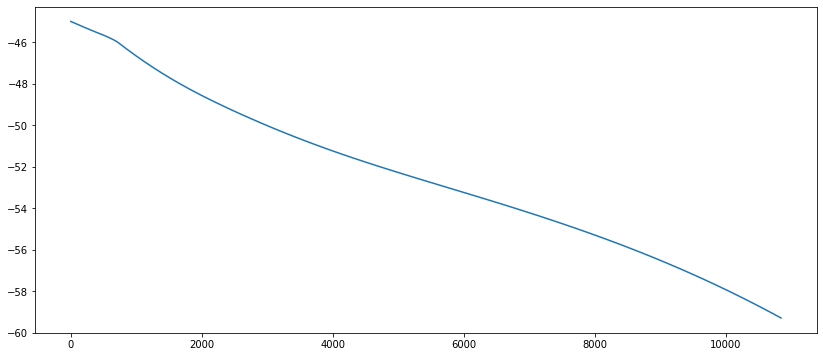

In [4]:
is2d = False

builder = DiagramBuilder()

starship = Starship(0.001, is2d, COM_rocket=COM_ROCKET)

starship_plant = starship.GetPlant()

starship_system = builder.AddSystem(starship.GetDiagram())

visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

meshcat.Delete()

X_logger = LogVectorOutput(starship_system.GetOutputPort("state"), builder)

diagram = builder.Build()
simulator = Simulator(diagram)

sim_context = simulator.get_mutable_context()
plant_context = starship_plant.GetMyContextFromRoot(sim_context)

starship_plant.get_actuation_input_port().FixValue(plant_context, np.zeros(4))

#initial condition
if is2d:
    starship.init(context = plant_context, joint_pos = [0,50, np.pi/8], joint_vel = [0,0,0])
else:
    starship.init(context = plant_context, angles = [0.37 for _ in range(4)],
                                 V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-45]),
                                 X_WB = RigidTransform(RotationMatrix.MakeYRotation(0),[0, 0, 50]))


q0 = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
q0 = starship.StateView(q0)


simulator.set_target_realtime_rate(1.0)
animator = visualizer.StartRecording()
for t in np.hstack((np.arange(0, 10, 1.0/32.0))):
    q = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
    frame = animator.frame(sim_context.get_time())
    sq = starship.StateView(q)
    animator.SetProperty(frame, "/Cameras/default/rotated/<object>", "position", [0, 0, 30])
    animator.SetTransform(frame, "/drake", RigidTransform(p = [-sq.body_x, -sq.body_y, -sq.body_z]))

    simulator.AdvanceTo(t)
    diagram.Publish(sim_context)

visualizer.PublishRecording()

qf = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
qf = starship.StateView(qf)

x_log = starship.StateView(X_logger.FindLog(sim_context).data())

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_log.body_vz)


In [5]:
def getq0(X_WB, V_WB, duration = -1, angles = [1.4, 1.4, 1.4,1.4], hasengine = False):
    builder = DiagramBuilder()

    starship = Starship(0.0001, planar = False, has_engine= hasengine)
    starship_plant = starship.GetPlant()
    starship_system = builder.AddSystem(starship.GetDiagram())
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    simulator = Simulator(diagram)

    sim_context = simulator.get_mutable_context()
    plant_context = starship_plant.GetMyContextFromRoot(sim_context)

    if hasengine:
        starship_system.GetInputPort("input").FixValue(starship.CreateDefaultContext(), np.zeros(7))
    else:
        starship_system.GetInputPort("input").FixValue(starship.CreateDefaultContext(), np.zeros(4))

    #initial condition
    starship.init(context = plant_context, angels= angles, V_WB = V_WB, X_WB = X_WB)
    
    simulator.AdvanceTo(1e-2)
    q0 = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
    q0 = starship.StateView(q0)
    
    knots = [q0[:]]
    t_breaks = [0.0]
    while t_breaks[-1] < duration:
        t_breaks += [t_breaks[-1] + 1/32.0]
        simulator.AdvanceTo(t_breaks[-1])
        q = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
        knots += [q]

    if duration > 0 :
        x_trajectory = PiecewisePolynomial.FirstOrderHold(t_breaks, np.column_stack(knots))
    else:
        x_trajectory = None

    return q0, x_trajectory



In [6]:
X_WB = RigidTransform(RotationMatrix(),[0, 0, 200])
V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-40])
starship.init(context = plant_context, V_WB = V_WB, X_WB = X_WB)
q0, _ = getq0(X_WB, V_WB, -1, [1.56 for _ in range(4)], hasengine=True)

q0

state(body_qw=1.0, body_qx=9.111379698344979e-14, body_qy=-6.900970516679598e-08, body_qz=-3.583170895320288e-14, body_x=-1.8319484475302807e-05, body_y=-5.994698458120798e-14, body_z=199.59977758015597, Joint_Leg_R_p=1.567873411312309, Joint_Leg_L_p=1.5678734113119746, Joint_Arm_R_p=1.5678730448742706, Joint_Arm_L_p=1.5678730448736455, Joint_Gimbal_x_p=0.0, Joint_Gimbal_y_p=0.0, body_wx=4.714072273025066e-11, body_wy=-1.1300029538231951e-05, body_wz=-7.267073032495701e-12, body_vx=-0.0018720580580745445, body_vy=-6.007585552479265e-12, body_vz=-40.043996428713626, Joint_Leg_R_v=-0.29861193072719977, Joint_Leg_L_v=-0.29861193082115844, Joint_Arm_R_v=-0.29864669857897563, Joint_Arm_L_v=-0.29864669868210675, Joint_Gimbal_x_v=0.0, Joint_Gimbal_y_v=0.0)

In [7]:
def VisualizeTraj(x_traj, u_traj = None, track = True, hasengine = False):
    # Animate trajectory
    builder = DiagramBuilder()
    starship = Starship(0.1, False, has_engine=hasengine)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
 
    animator = visualizer.StartRecording()
    vertices = [[],[], []]
    U_logs = []
    for t in np.hstack((np.arange(x_traj.start_time(), x_traj.end_time(),1.0/60.0), x_traj.end_time())):
        context.SetTime(t)
        q = x_traj.value(t)
        if u_traj:
            U_logs.append(u_traj.value(t))
        context.SetDiscreteState(q)
        frame = animator.frame(context.get_time())
        sq = starship.StateView(q)
        if track:
            animator.SetProperty(frame, "/Cameras/default/rotated/<object>", "position", [0, 0, 50])
            animator.SetTransform(frame, "/drake", RigidTransform(p = [-sq.body_x, -sq.body_y, -sq.body_z]))
        
        if hasengine:
            if u_traj.value(t)[-1] > 10: #modify this 
                visible = False
            else:
                visible = True
            animator.SetProperty(frame, "/drake/visual/<object_name>/Link_Gimbal_x", "visible", visible)

        vertices[0].append(sq.body_x[0])
        vertices[1].append(sq.body_y[0])
        vertices[2].append(sq.body_z[0])
    
        diagram.Publish(context)

    if not track:
        meshcat.SetLine("COM", np.stack(vertices), rgba = Rgba(0, 0, 0.5))

    visualizer.StopRecording()
    visualizer.PublishRecording()

    return visualizer, starship.GetLogs(context)[0], np.hstack(U_logs)

# Trajectory Optimization

In [8]:
options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, "debugOutput.txt")
snopt= SnoptSolver().solver_id()
options.SetOption(snopt, 'Iterations Limits', 1e5)
options.SetOption(snopt, 'Major Iterations Limit', 200) 
options.SetOption(snopt, 'Major Feasibility Tolerance', 5e-6)
options.SetOption(snopt, 'Major Optimality Tolerance', 1e-4)
options.SetOption(snopt, 'Superbasics limit', 2000)
options.SetOption(snopt, 'Linesearch tolerance', 0.9)

In [37]:
def dirtran_orientation(Rf = None, px = None, py = None, duration = 5, time_step = 0.1, sol=None):
    builder = DiagramBuilder()

    starship = Starship(time_step, False, COM_rocket=COM_ROCKET)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()
    
    
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    plant_context = starship_plant.GetMyContextFromRoot(context)

   #initial condition
    X_WB = RigidTransform(RotationMatrix(),[0, 0, 0])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-50])
    starship.init(context = plant_context, angles = [1.56, 1.56, 1.56, 1.56], V_WB = V_WB, X_WB = X_WB)
    q0, _ = getq0(X_WB, V_WB, -1, [1.56, 1.56, 1.56, 1.56], False)


    N = int(np.ceil(duration/time_step))
    if N % 2 == 0:
        N += 1

    #N = int(5/0.001)
    dirtran = DirectTranscription(starship_system, starship.CreateDefaultContext(), N)      
    prog = dirtran.prog()

    u = dirtran.input()
    for i in range(len(u)):
        torque_limit = 500  # Nm
        #dirtran.AddConstraintToAllKnotPoints(u[i] >=- torque_limit)
        #dirtran.AddConstraintToAllKnotPoints(u[i] <=torque_limit)

    #initial conditions
    prog.AddBoundingBoxConstraint(q0[:], q0[:], dirtran.initial_state())
    
    # Joint positions and velocities
    sf = starship.StateView(dirtran.final_state())
    #prog.AddConstraint(OrientationConstraint(starship_plant,
    # starship_plant.GetFrameByName("body"), RotationMatrix(),
    # starship_plant.world_frame(), RotationMatrix.MakeYRotation(0.3),
    #    0.1, starship.CreateDefaultContext()), sf[:starship_plant.num_positions()])
    if not Rf is None:
        prog.AddConstraint(OrientationConstraint(starship_plant,
        starship_plant.GetFrameByName("com_frame"), Rf,
        starship_plant.world_frame(), RotationMatrix(), #.MakeZRotation(-np.pi/2),#.MakeZRotation(-np.pi/2),
            0.1, plant_context), sf[:starship_plant.num_positions()])
        
    if not px is None:
        prog.AddBoundingBoxConstraint(px - 50, px + 50, sf.body_x)

    if not py is None:
        prog.AddBoundingBoxConstraint(py - 50, py + 50, sf.body_y)

    #State Constraints
    s = starship.StateView(dirtran.state())
    pos_limit = 1.57
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Leg_R_p <= pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Leg_R_p >=-pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Leg_L_p <= pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Leg_L_p >=-pos_limit)

    dirtran.AddConstraintToAllKnotPoints(s.Joint_Arm_R_p <= pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Arm_R_p >=-pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Arm_L_p <= pos_limit)
    dirtran.AddConstraintToAllKnotPoints(s.Joint_Arm_L_p >=-pos_limit)

    #dirtran.AddConstraintToAllKnotPoints(s.body_z <= q0.body_z)
    omega = 20
    # FOR ROLL
    #dirtran.AddConstraintToAllKnotPoints(s.body_qy <= 0.02)
    #dirtran.AddConstraintToAllKnotPoints(s.body_qy >=-0.02)
    #dirtran.AddConstraintToAllKnotPoints(s.body_qz <= 0.02)
    #dirtran.AddConstraintToAllKnotPoints(s.body_qz >=-0.02)
 
    #dirtran.AddConstraintToAllKnotPoints(s.body_wx <= omega)
    #dirtran.AddConstraintToAllKnotPoints(s.body_wx >=-omega)
    #dirtran.AddConstraintToAllKnotPoints(s.body_wy <= omega)
    #dirtran.AddConstraintToAllKnotPoints(s.body_wy >=-omega)
    #dirtran.AddConstraintToAllKnotPoints(s.body_wz <= omega)
    #dirtran.AddConstraintToAllKnotPoints(s.body_wz >=-omega)

    #dirtran.AddConstraintToAllKnotPoints(s.body_y <= 150)
    #dirtran.AddConstraintToAllKnotPoints(s.body_y >= -150)

    #quartenion constraint avoid singular body hinge inertia
    for n in range(N):
        s = starship.StateView(dirtran.state(n))
        AddUnitQuaternionConstraintOnPlant(starship_plant, s[:starship_plant.num_positions()], prog)
        if px or py:
            prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant, starship_plant.GetFrameByName("body"), np.array([[0], [1], [0]]),
                                          starship_plant.world_frame(),np.array([[0], [1], [0]]), 0, 0, plant_context))
        #add cost
        #guess = q0[:] + (qf[:] - q0[:])* n / (N - 1)
        #sg = starship.StateView(guess)
        #if n > 1*N/3:
        #    prog.AddConstraint(OrientationConstraint(starship_plant,
        #    starship_plant.GetFrameByName("com_frame"), Rf,
        #    starship_plant.world_frame(), RotationMatrix(), #.MakeZRotation(-np.pi/2),#.MakeZRotation(-np.pi/2),
        #        0.1, plant_context), s[:starship_plant.num_positions()])



        #prog.AddCost((s.body_vx - sg.body_vx) ** 2)
        #prog.AddConstraint(s.body_vx >= sg.body_vx - 1)

    # Cost
    # This cost motivates the legs to actuates at similar activity level as the arms 
    u = dirtran.input()
    leg_u = u[:1]
    arm_u = u[2:]
    dirtran.AddRunningCost(leg_u.dot(leg_u) + starship.Leg_Area/starship.Arm_Area * arm_u.dot(arm_u)) 
 

    def plot_traj(times, states):
        s = starship.StateView(states)
        vertices = np.vstack([s.body_x, s.body_y, s.body_z])
        meshcat.SetLine("dirtran", vertices, rgba = Rgba(0, 0, 0.5))
    
    #dirtran.AddStateTrajectoryCallback(plot_traj)

    #inital guess is a linear interplation of states
    for n in range(N):
        prog.SetInitialGuess(dirtran.state(n)[:starship_plant.num_positions()], q0[:starship_plant.num_positions()])
    if not sol is None:
        dirtran.SetInitialTrajectory(sol[1],sol[0])
 


#    sf_d = starship.StateView(np.zeros(14))
#    sf_d.Joint_body_y = -5
#    prog.AddQuadraticErrorCost(np.diag([0,10,0, #Joint body positions
#                                        0,0,0,0, #joint positinos
#                                        0, 0, 10, #joint body velocities
#                                        0,0,0,0]), sf_d[:], #joint vel
#                            dirtran.final_state())
#
#

    solver = SnoptSolver()
    #solver = MosekSolver()
    #solver = GurobiSolver()
    result = solver.Solve(prog, solver_options = options)

    for c in result.GetInfeasibleConstraints(prog):
        pass
        #print(c)
 
    if result.is_success():
        print('success')
    else:
        print("fail")
    #assert result.is_success()

    x_traj = dirtran.ReconstructStateTrajectory(result)
    u_traj = dirtran.ReconstructInputTrajectory(result)

    return x_traj, u_traj


### Starship can Yaw

In [21]:
yaw =  dirtran_orientation(RotationMatrix.MakeZRotation(np.pi/2), duration = 3, time_step=0.01)
print("Finished First Solve")
_, x_log, u_log = VisualizeTraj(yaw[0], yaw[1], True, False)
t = np.linspace(yaw[0].start_time(), yaw[0].end_time(), x_log.body_x.shape[0])

TypeError: AddConstraint(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.solvers.mathematicalprogram.MathematicalProgram, func: function, lb: numpy.ndarray[numpy.float64[m, 1]], ub: numpy.ndarray[numpy.float64[m, 1]], vars: numpy.ndarray[object[m, 1]], description: str = '') -> pydrake.solvers.mathematicalprogram.Binding[Constraint]
    2. (self: pydrake.solvers.mathematicalprogram.MathematicalProgram, arg0: pydrake.symbolic.Expression, arg1: float, arg2: float) -> pydrake.solvers.mathematicalprogram.Binding[Constraint]
    3. (self: pydrake.solvers.mathematicalprogram.MathematicalProgram, arg0: pydrake.symbolic.Formula) -> pydrake.solvers.mathematicalprogram.Binding[Constraint]
    4. (self: pydrake.solvers.mathematicalprogram.MathematicalProgram, constraint: pydrake.solvers.mathematicalprogram.Constraint, vars: numpy.ndarray[object[m, 1]]) -> pydrake.solvers.mathematicalprogram.Binding[Constraint]
    5. (self: pydrake.solvers.mathematicalprogram.MathematicalProgram, formulas: numpy.ndarray[object[m, n], flags.f_contiguous]) -> pydrake.solvers.mathematicalprogram.Binding[Constraint]

Invoked with: <pydrake.solvers.mathematicalprogram.MathematicalProgram object at 0x7fe5fc25d970>, <pydrake.multibody.inverse_kinematics.AngleBetweenVectorsConstraint object at 0x7fe5fc59f6b0>

## We can make the rocket Roll
Too short of a time span violates constraints 

In [31]:
#fastRoll =  dirtran_orientation(RotationMatrix.MakeXRotation(172 / 180  * np.pi), duration = 4.0, time_step = 0.02)
fastRoll =  dirtran_orientation(RotationMatrix.MakeXRotation(172 / 180  * np.pi), duration = 4.0, time_step = 0.01)
_, x_log, u_log = VisualizeTraj(fastRoll[0], fastRoll[1], True, False)
t = np.linspace(fastRoll[0].start_time(), fastRoll[0].end_time(), x_log.body_x.shape[0])

fail


In [53]:
standup =  dirtran_orientation(RotationMatrix.MakeYRotation(1.1*np.pi/2), duration = 8.0, time_step = 0.2)
standup =  dirtran_orientation(RotationMatrix.MakeYRotation(1.1*np.pi/2), duration = 8.0, time_step = 0.02, sol=standup)
_, x_log, u_log = VisualizeTraj(standup[0], standup[1], True, False)
t = np.linspace(standup[0].start_time(), standup[0].end_time(), x_log.body_x.shape[0])

fail
fail


In [ ]:
moveX =  dirtran_orientation(py=150, duration = 5, time_step = 0.02)
_, x_log = VisualizeTraj(moveX[0])

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_log.body_vz)

# Universal Constraints Starship must adhere to 

In [9]:
def AddBasicConstraints(starship, trajopt, N, has_engine):
    starship_plant = starship.GetPlant()
    prog = trajopt.prog()
    s = starship.StateView(trajopt.state())
    u = trajopt.input()

    ## Add position Constraints of Flaps
    max_flap_position = np.pi/2 #rad
    max_flap_omega = 13 #rad/s
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_R_p <=   max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_R_p >= - max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_L_p <=   max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_L_p >= - max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_R_p <=   max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_R_p >= - max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_L_p <=   max_flap_position)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_L_p >= - max_flap_position)

    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_R_v <=   max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_R_v >= - max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_L_v <=   max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Leg_L_v >= - max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_R_v <=   max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_R_v >= - max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_L_v <=   max_flap_omega)
    trajopt.AddConstraintToAllKnotPoints(s.Joint_Arm_L_v >= - max_flap_omega)

   
    ## Add angular velocity constraints 
    max_body_omega = 13 #rad/s
    trajopt.AddConstraintToAllKnotPoints(s.body_wx <=   max_body_omega)
    trajopt.AddConstraintToAllKnotPoints(s.body_wx >= - max_body_omega)
    trajopt.AddConstraintToAllKnotPoints(s.body_wy <=   max_body_omega)
    trajopt.AddConstraintToAllKnotPoints(s.body_wy >= - max_body_omega)
    trajopt.AddConstraintToAllKnotPoints(s.body_wz <=   max_body_omega)
    trajopt.AddConstraintToAllKnotPoints(s.body_wz >= - max_body_omega)

    #Need Unit Quaternion Constraint. Will yield singular body hinge inertia otherwise 
    for n in range(N):
        s = starship.StateView(trajopt.state(n))
        AddUnitQuaternionConstraintOnPlant(starship_plant, s[:starship_plant.num_positions()], prog)
        #need to set an inital guess for the quaternion which is nonzer0
        prog.SetInitialGuess(trajopt.state(n)[0], 1)
    
    max_gimbal_position = np.pi/6
    if has_engine:
        #add position constraints for gimbal
        #trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_y_p <=   max_gimbal_position)
        #trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_y_p >= - max_gimbal_position)
        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_x_p <=   max_gimbal_position)
        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_x_p >= - max_gimbal_position)

        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_y_p <=   max_flap_omega)
        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_y_p >= - max_flap_omega)
        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_x_p <=   max_flap_omega)
        trajopt.AddConstraintToAllKnotPoints(s.Joint_Gimbal_x_p >= - max_flap_omega)
    
    #Add input limits 
    max_motor_torque = 500 #Nm
    for i in range(4):
        trajopt.AddConstraintToAllKnotPoints(u[i] <= max_motor_torque)
        trajopt.AddConstraintToAllKnotPoints(u[i] >= -max_motor_torque)


    #equivalence of three raptor engines
    thrust_limit = 3 *  1.81  # N
    if has_engine:
        trajopt.AddConstraintToAllKnotPoints(u[5] <= max_motor_torque)
        trajopt.AddConstraintToAllKnotPoints(u[5] >= -max_motor_torque)
        trajopt.AddConstraintToAllKnotPoints(u[6] <= max_motor_torque)
        trajopt.AddConstraintToAllKnotPoints(u[6] >= -max_motor_torque)

        trajopt.AddConstraintToAllKnotPoints(u[6] >= 0)
        trajopt.AddConstraintToAllKnotPoints(u[6] <= thrust_limit)

    #set scalings 
    for n in range(N):
        s = starship.StateView(trajopt.state(n))
        u = trajopt.input(n)
        prog.SetVariableScaling(s.Joint_Arm_L_p, max_flap_position)
        prog.SetVariableScaling(s.Joint_Arm_R_p, max_flap_position)
        prog.SetVariableScaling(s.Joint_Leg_L_p, max_flap_position)
        prog.caling(s.Joint_Leg_R_p, max_flap_position)
        prog.SetVariableScaling(s.Joint_Arm_L_p, max_flap_omega)
        prog.SetVariableScaling(s.Joint_Arm_R_p, max_flap_omega)
        prog.SetVariableScaling(s.Joint_Leg_L_p, max_flap_omega)
        prog.SetVariableScaling(s.Joint_Leg_R_p, max_flap_omega)


        for i in range(4):
            prog.SetVariableScaling(u[i], max_motor_torque)

        if has_engine:
            prog.SetVariableScaling(s.Joint_Gimbal_x_p, max_gimbal_position)
            prog.caling(s.Joint_Gimbal_y_p, max_gimbal_position)
            prog.SetVariableScaling(s.Joint_Gimbal_x_p, max_flap_omega)
            prog.SetVariableScaling(s.Joint_Gimbal_y_p, max_flap_omega)

            prog.SetVariableScaling(u[4], max_motor_torque)
            prog.SetVariableScaling(u[5], max_motor_torque)
            prog.SetVariableScaling(u[6], thrust_limit)

# Yaw

In [12]:
def dircol_yaw(degrees, duration_bounds, max_step = 0.1, sol=None):
    builder = DiagramBuilder()

    starship = Starship(0, False, COM_rocket=COM_ROCKET, has_engine=False)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()
    
    
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    plant_context = starship_plant.GetMyContextFromRoot(context)

    
    X_WB = RigidTransform(RotationMatrix(),[0, 0, 0])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,0])
    angles = [1.56 for _ in range(4)]
    starship.init(context = plant_context, angles = angles, V_WB = V_WB, X_WB = X_WB)
    q0, _ = getq0(X_WB, V_WB, -1, angles, hasengine=False)

    N = int(np.ceil(duration_bounds[1]/max_step))
    if N % 2 == 0:
        N += 1

    dircol = DirectCollocation(starship_system, starship.CreateDefaultContext(), N, duration_bounds[0]/N, duration_bounds[1]/N)      
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    AddBasicConstraints(starship, dircol, N, False)

    #initial conditions
    prog.AddBoundingBoxConstraint(q0[:], q0[:], dircol.initial_state())
    si = starship.StateView(dircol.initial_state())
    #prog.AddBoundingBoxConstraint(100, 100, si.body_z)
    #prog.AddBoundingBoxConstraint(0, 0, si.body_x)
    #prog.AddBoundingBoxConstraint(0, 0, si.body_y)
    #prog.AddBoundingBoxConstraint(1.0, 1.0, si.body_qw)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qx)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qy)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qz)
    #prog.AddBoundingBoxConstraint(-0.05, 0.05, si.body_wx)
    #prog.AddBoundingBoxConstraint(-0.05, 0.05, si.body_wy)
    #prog.AddBoundingBoxConstraint(-0.05, 0.05, si.body_wz)

    #prog.AddBoundingBoxConstraint(0, 0, si.body_vx)
    #prog.AddBoundingBoxConstraint(0, 0, si.body_vy)
    #prog.AddBoundingBoxConstraint(-60, 0, si.body_vz)
    #prog.AddBoundingBoxConstraint(np.pi/6,np.pi/2, si.Joint_Leg_L_p)
    #prog.AddBoundingBoxConstraint(np.pi/6,np.pi/2, si.Joint_Leg_R_p)
    #prog.AddBoundingBoxConstraint(np.pi/6,np.pi/2, si.Joint_Arm_L_p)
    #prog.AddBoundingBoxConstraint(np.pi/6,np.pi/2, si.Joint_Arm_R_p)

    # Joint positions and velocities
    sf = starship.StateView(dircol.final_state())
    #prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant,
    #        starship_plant.GetFrameByName("com_frame"), [1,0,0],
    #        starship_plant.world_frame(), [1,0,0], degrees / 180.0 * np.pi, degrees / 180.0 * np.pi , plant_context),
    #        sf[:starship_plant.num_positions()])

    prog.AddConstraint(OrientationConstraint(starship_plant,
            starship_plant.GetFrameByName("com_frame"), RotationMatrix.MakeZRotation(degrees / 180.0 * np.pi),
            starship_plant.world_frame(), RotationMatrix(),#.MakeYRotation(-np.pi/2),#.MakeZRotation(-np.pi/2),
                0.1, plant_context), sf[:starship_plant.num_positions()])
   

    #Yaw in place!
    #prog.AddBoundingBoxConstraint(q0.body_x, q0.body_x, sf.body_x)
    #prog.AddBoundingBoxConstraint(q0.body_y, q0.body_y, sf.body_y)


    s = starship.StateView(dircol.state())
    #bound the positions of the body
    dircol.AddConstraintToAllKnotPoints(s.body_x <=   100)
    dircol.AddConstraintToAllKnotPoints(s.body_x >= - 100)
    dircol.AddConstraintToAllKnotPoints(s.body_y <=   100)
    dircol.AddConstraintToAllKnotPoints(s.body_y >= - 100)
    dircol.AddConstraintToAllKnotPoints(s.body_z <=   1)
    dircol.AddConstraintToAllKnotPoints(s.body_z >= - 2000) 

    #Set Variable Scaling
    for n in range(N):
        s = starship.StateView(dircol.state(n))
        prog.SetVariableScaling(s.body_z, 2000)
        prog.SetVariableScaling(s.body_x, 100)
        prog.SetVariableScaling(s.body_y, 100)
        prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant,
                starship_plant.GetFrameByName("com_frame"), [0,0,1],
                starship_plant.world_frame(), [0,0,1], 0, 0, plant_context),
                s[:starship_plant.num_positions()])

        #prog.AddBoundingBoxConstraint(-60, 0, s.body_vz)
        #prog.AddConstraint(s.Joint_Leg_L_p >=0.1)
        #prog.AddConstraint(s.Joint_Leg_R_p >=0.1)
        #prog.AddConstraint(s.Joint_Arm_L_p >=0.1)
        #prog.AddConstraint(s.Joint_Arm_R_p >=0.1)

    # Cost
    # This cost motivates the legs to actuates at similar activity level as the arms 
    u = dircol.input()
    leg_u = u[:1]
    arm_u = u[2:]
    dircol.AddRunningCost(leg_u.dot(leg_u) + starship.Leg_Area/starship.Arm_Area * arm_u.dot(arm_u))

    #Try to roll in place
#    sf_d = starship.StateView(np.zeros(21))
#    prog.AddQuadraticErrorCost(np.diag([0,0,0,0,1,1,0, #body
#                                        0,0,0,0, #joint positinos
#                                        0, 0, 0, 0, 0, 0, #body velocity
#                                        0,0,0,0]), sf_d[:], #joint vel
#                            dircol.final_state())
#

    def plot_traj(times, states):
        s = starship.StateView(states)
        vertices = np.vstack([s.body_x, s.body_y, s.body_z])
        meshcat.SetLine("dircol", vertices, rgba = Rgba(0, 0, 0.5))
    
    dircol.AddStateTrajectoryCallback(plot_traj)

    if not sol is None:
        dircol.SetInitialTrajectory(sol[1],sol[0])

    solver = SnoptSolver()
    result = solver.Solve(prog, solver_options = options)

    if result.is_success():
        print('success')
    else:
        print("fail")
    #assert result.is_success()

    x_traj = dircol.ReconstructStateTrajectory(result)
    u_traj = dircol.ReconstructInputTrajectory(result)

    return x_traj, u_traj


In [13]:
yawing = dircol_yaw(60, [4,8], 0.1)

fail


In [14]:
_, x_log, u_log = VisualizeTraj(yawing[0], yawing[1], True, False)
t = np.linspace(yawing[0].start_time(), yawing[0].end_time(), x_log.body_x.shape[0])

# Roll

In [26]:
def dircol_roll(degrees, duration_bounds, max_step = 0.1, sol=None):
    builder = DiagramBuilder()

    starship = Starship(0, False, COM_rocket=COM_ROCKET, has_engine=False)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()
    
    
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    plant_context = starship_plant.GetMyContextFromRoot(context)

    #initial condition
    X_WB = RigidTransform(RotationMatrix(),[0, 0, 0])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-50])
    starship.init(context = plant_context, angles = [1.2 for _ in range(4)], V_WB = V_WB, X_WB = X_WB)
    q0, _ = getq0(X_WB, V_WB, -1, [1.56 for _ in range(4)], hasengine=False)
    #final condition
    X_WB = RigidTransform(RotationMatrix.MakeXRotation(degrees / 180.0 * np.pi),[0, 0, 600])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-40])
    starship.init(context = plant_context, angles = [1.2 for _ in range(4)], V_WB = V_WB, X_WB = X_WB)
    qf, _ = getq0(X_WB, V_WB, -1, [1.56 for _ in range(4)], hasengine=False)
    
    N = int(np.ceil(duration_bounds[1]/max_step))
    if N % 2 == 0:
        N += 1

    dircol = DirectCollocation(starship_system, starship.CreateDefaultContext(), N, duration_bounds[0]/N, duration_bounds[1]/N)      
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    AddBasicConstraints(starship, dircol, N, False)

    #initial conditions
    prog.AddBoundingBoxConstraint(q0[:], q0[:], dircol.initial_state())
    #prog.AddBoundingBoxConstraint(q0.body_z, q0.body_z, si.body_z)
    #prog.AddBoundingBoxConstraint(q0.body_x, q0.body_x, si.body_x)
    #prog.AddBoundingBoxConstraint(q0.body_y, q0.body_y, si.body_y)
    #prog.AddBoundingBoxConstraint(1.0, 1.0, si.body_qw)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qx)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qy)
    #prog.AddBoundingBoxConstraint(0.0, 0.0, si.body_qz)


    # Joint positions and velocities
    sf = starship.StateView(dircol.final_state())
    prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant,
            starship_plant.GetFrameByName("com_frame"), [0,0,1],
            starship_plant.world_frame(), [0,0,1], degrees / 180.0 * np.pi, degrees / 180.0 * np.pi, plant_context),
            sf[:starship_plant.num_positions()])

    s = starship.StateView(dircol.state())
    #bound the positions of the body
    dircol.AddConstraintToAllKnotPoints(s.body_x <= 100)
    dircol.AddConstraintToAllKnotPoints(s.body_x >= -100)
    dircol.AddConstraintToAllKnotPoints(s.body_y <= 100)
    dircol.AddConstraintToAllKnotPoints(s.body_y >= -100)

    for n in range(N):
        #Set Variable Scaling
        s = starship.StateView(dircol.state(n))
        prog.SetVariableScaling(s.body_z, 100)
        prog.SetVariableScaling(s.body_x, 100)
        prog.SetVariableScaling(s.body_y, 100)


    # Cost
    # This cost motivates the legs to actuates at similar activity level as the arms 
    u = dircol.input()
    leg_u = u[:1]
    arm_u = u[2:]
    dircol.AddRunningCost(leg_u.dot(leg_u) + starship.Leg_Area/starship.Arm_Area * arm_u.dot(arm_u))

#    sf_d = starship.StateView(qf)
#    #TODO how about rolling velocity?
#    prog.AddQuadraticErrorCost(np.diag([10,10,10,10,0,0,0, #body
#                                        0,0,0,0,0,0, #joint positinos
#                                        0, 0, 0, 0, 0, 0, #body veelocity
#                                        0,0,0,0,0,0]), sf_d[:], #joint vel
#                            dircol.final_state())
#

    def plot_traj(times, states):
        s = starship.StateView(states)
        vertices = np.vstack([s.body_x, s.body_y, s.body_z])
        meshcat.SetLine("dircol", vertices, rgba = Rgba(0, 0, 0.5))
    
    #dircol.AddStateTrajectoryCallback(plot_traj)

    if not sol is None:
        dircol.SetInitialTrajectory(sol[1],sol[0])

    solver = SnoptSolver()
    result = solver.Solve(prog, solver_options = options)

    if result.is_success():
        print('success')
    else:
        print("fail")
    #assert result.is_success()

    x_traj = dircol.ReconstructStateTrajectory(result)
    u_traj = dircol.ReconstructInputTrajectory(result)

    return x_traj, u_traj


In [27]:
rolling = dircol_roll(170, [2,8], 0.1)

fail


In [29]:
_, x_log, u_log = VisualizeTraj(rolling[0], rolling[1], True, False)
t = np.linspace(rolling[0].start_time(), rolling[0].end_time(), x_log.body_x.shape[0])

# Stand Up

In [42]:
def dircol_standup(duration_bounds, max_step = 0.1, sol=None):
    builder = DiagramBuilder()

    starship = Starship(0, False, COM_rocket=COM_ROCKET, has_engine=False)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()
    
    
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    plant_context = starship_plant.GetMyContextFromRoot(context)

    #initial condition
    X_WB = RigidTransform(RotationMatrix(),[0, 0, 0])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-50])
    starship.init(context = plant_context, angles = [1.2 for _ in range(4)], V_WB = V_WB, X_WB = X_WB)
    q0, _ = getq0(X_WB, V_WB, -1, [1.56 for _ in range(4)], hasengine=False)
    
    N = int(np.ceil(duration_bounds[1]/max_step))
    if N % 2 == 0:
        N += 1

    dircol = DirectCollocation(starship_system, starship.CreateDefaultContext(), N, duration_bounds[0]/N, duration_bounds[1]/N)      
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    AddBasicConstraints(starship, dircol, N, False)

    #initial conditions
    prog.AddBoundingBoxConstraint(q0[:], q0[:], dircol.initial_state())

    # Joint positions and velocities
    sf = starship.StateView(dircol.final_state())
    prog.AddConstraint(OrientationConstraint(starship_plant,
            starship_plant.GetFrameByName("com_frame"), RotationMatrix.MakeYRotation(np.pi/2),
            starship_plant.world_frame(), RotationMatrix(),#.MakeYRotation(-np.pi/2),#.MakeZRotation(-np.pi/2),
                0.1, plant_context), sf[:starship_plant.num_positions()])

    s = starship.StateView(dircol.state())
    #bound the positions of the body
    dircol.AddConstraintToAllKnotPoints(s.body_x <= 100)
    dircol.AddConstraintToAllKnotPoints(s.body_x >= -100)
    dircol.AddConstraintToAllKnotPoints(s.body_y <= 100)
    dircol.AddConstraintToAllKnotPoints(s.body_y >= -100)

    for n in range(N):
        #Set Variable Scaling
        s = starship.StateView(dircol.state(n))
        prog.SetVariableScaling(s.body_z, 400)
        prog.SetVariableScaling(s.body_x, 100)
        prog.SetVariableScaling(s.body_y, 100)

    # Cost
    # This cost motivates the legs to actuates at similar activity level as the arms 
    u = dircol.input()
    leg_u = u[:1]
    arm_u = u[2:]
    dircol.AddRunningCost(leg_u.dot(leg_u) + starship.Leg_Area/starship.Arm_Area * arm_u.dot(arm_u))

    def plot_traj(times, states):
        s = starship.StateView(states)
        vertices = np.vstack([s.body_x, s.body_y, s.body_z])
        meshcat.SetLine("dircol", vertices, rgba = Rgba(0, 0, 0.5))
    
    #dircol.AddStateTrajectoryCallback(plot_traj)

    if not sol is None:
        dircol.SetInitialTrajectory(sol[1],sol[0])

    solver = SnoptSolver()
    result = solver.Solve(prog, solver_options = options)

    if result.is_success():
        print('success')
    else:
        print("fail")
    #assert result.is_success()

    x_traj = dircol.ReconstructStateTrajectory(result)
    u_traj = dircol.ReconstructInputTrajectory(result)

    return x_traj, u_traj


In [43]:
standup = dircol_standup([2,8], 0.1)

fail


In [44]:
_, x_log, u_log = VisualizeTraj(standup[0], standup[1], True, False)
t = np.linspace(standup[0].start_time(), standup[0].end_time(), x_log.body_x.shape[0])

# Landing

In [27]:
def dircol_landing(duration_bounds, max_step = 0.1, sol=None):
    builder = DiagramBuilder()

    starship = Starship(0, False, COM_rocket=COM_ROCKET, has_engine=True)
    starship_system = builder.AddSystem(starship.GetDiagram())
    
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, starship_system.GetOutputPort("geometry_query"), meshcat)

    meshcat.Delete()
    
    
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    plant_context = starship_plant.GetMyContextFromRoot(context)

    #initial condition
    X_WB = RigidTransform(RotationMatrix(),[0, 0, 250])
    V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-15])
    starship.init(context = plant_context, angles = [1.56 for _ in range(4)], V_WB = V_WB, X_WB = X_WB)
    q0, _ = getq0(X_WB, V_WB, -1, [1.56 for _ in range(4)], hasengine=True)

    N = int(np.ceil(duration_bounds[1]/max_step))
    if N % 2 == 0:
        N += 1

    dircol = DirectCollocation(starship_system, starship.CreateDefaultContext(), N, duration_bounds[0]/N, duration_bounds[1]/N)      
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    AddBasicConstraints(starship, dircol, N, True)


    #initial conditions
    prog.AddBoundingBoxConstraint(q0[:], q0[:], dircol.initial_state())

    # Joint positions and velocities
    sf = starship.StateView(dircol.final_state())
    prog.AddConstraint(OrientationConstraint(starship_plant,
            starship_plant.GetFrameByName("com_frame"), RotationMatrix.MakeYRotation(np.pi/2),
            starship_plant.world_frame(), RotationMatrix(),#.MakeYRotation(-np.pi/2),#.MakeZRotation(-np.pi/2),
                0.1, plant_context), sf[:starship_plant.num_positions()])
    prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant,
            starship_plant.GetFrameByName("body"), [1,0,0],
            starship_plant.world_frame(), [0,0,1], 0, 0.01, plant_context),sf[:starship_plant.num_positions()])
    

    #Landing positino constraint
    prog.AddBoundingBoxConstraint(-25,  25, sf.body_x)
    prog.AddBoundingBoxConstraint(-25,  25, sf.body_y)
    prog.AddBoundingBoxConstraint(21,  26, sf.body_z)

    #No velicty when landing 
    prog.AddBoundingBoxConstraint(-1, 1, sf.body_vx)
    prog.AddBoundingBoxConstraint(-1, 1, sf.body_vy)
    prog.AddBoundingBoxConstraint(-1, 1, sf.body_vz)
    prog.AddBoundingBoxConstraint(-0.05, 0.05, sf.body_wx)
    prog.AddBoundingBoxConstraint(-0.05, 0.05, sf.body_wy)
    prog.AddBoundingBoxConstraint(-0.05, 0.05, sf.body_wz)

    s = starship.StateView(dircol.state())
    #bound the positions of the body
    dircol.AddConstraintToAllKnotPoints(s.body_x <= 250)
    dircol.AddConstraintToAllKnotPoints(s.body_x >= -250)
    dircol.AddConstraintToAllKnotPoints(s.body_y <= 250)
    dircol.AddConstraintToAllKnotPoints(s.body_y >= -250)
    dircol.AddConstraintToAllKnotPoints(s.body_z <= q0.body_z)
    dircol.AddConstraintToAllKnotPoints(s.body_z >= 21) # don't penetrate ground

    #Set Variable Scaling
    for n in range(N):
        s = starship.StateView(dircol.state(n))
        prog.SetVariableScaling(s.body_z, q0.body_z)
        prog.SetVariableScaling(s.body_x, 250)
        prog.SetVariableScaling(s.body_y, 250)
        if n > 3*N/4:
            prog.AddConstraint(AngleBetweenVectorsConstraint(starship_plant,
                    starship_plant.GetFrameByName("body"), [1,0,0],
                    starship_plant.world_frame(), [0,0,1], 0, 0.6, plant_context),sf[:starship_plant.num_positions()])


    # Cost
    # This cost motivates the legs to actuates at similar activity level as the arms 
    u = dircol.input()
    leg_u = u[:1]
    arm_u = u[2:4]
    gimbal_u = u[4:6]
    thruster_u = u[6]
    #dircol.AddRunningCost(leg_u.dot(leg_u) + starship.Leg_Area/starship.Arm_Area * arm_u.dot(arm_u) )#+ 1 * thruster ** 2) 
    s = starship.StateView(dircol.state())
    dircol.AddRunningCost(u[:6].dot(u[:6]))

    #TODO cost is wrong
    #sf_d = starship.StateView(q0)
    #sf_d.body_z = 21.6
    #prog.AddQuadraticErrorCost(np.diag([10,10,10,10,10,10,10, #body
    #                                    0,0,0,0,0,0, #joint positinos
    #                                    10, 10, 10, 10, 10, 10, #body veelocity
    #                                    1,1,1,1,1,1]), sf_d[:], #joint vel
    #                        dircol.final_state())


    def plot_traj(times, states):
        s = starship.StateView(states)
        vertices = np.vstack([s.body_x, s.body_y, s.body_z])
        meshcat.SetLine("dircol", vertices, rgba = Rgba(0, 0, 0.5))
    
    #dircol.AddStateTrajectoryCallback(plot_traj)

    if not sol is None:
        dircol.SetInitialTrajectory(sol[1],sol[0])

    solver = SnoptSolver()
    result = solver.Solve(prog, solver_options = options)

    if result.is_success():
        print('success')
    else:
        print("fail")
    #assert result.is_success()

    for c in result.GetInfeasibleConstraints(prog):
        pass
        #print(c)

    x_traj = dircol.ReconstructStateTrajectory(result)
    u_traj = dircol.ReconstructInputTrajectory(result)

    return x_traj, u_traj


In [17]:
landing = dircol_landing([15,35], 2)

fail


In [28]:
landing = dircol_landing([15,35], 0.5)

fail


In [29]:
_, x_log, u_log = VisualizeTraj(landing[0], landing[1], True, True)
t = np.linspace(landing[0].start_time(), landing[0].end_time(), x_log.body_x.shape[0])

# Analysis

Text(0, 0.5, 'z velocity (m/s)')

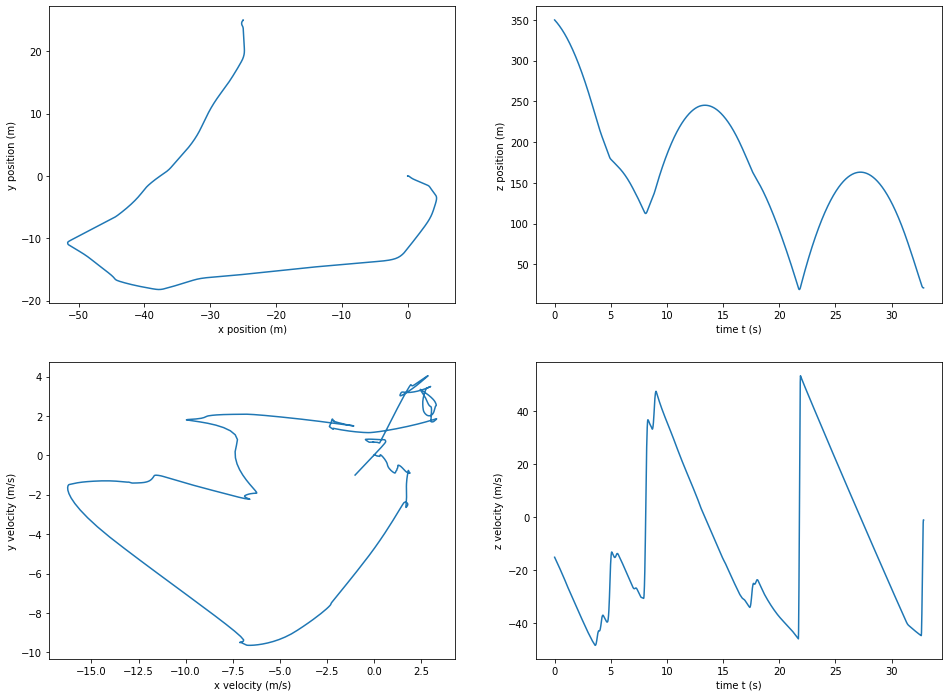

In [24]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(16,12))
ax[0,0].plot(x_log.body_x, x_log.body_y)
ax[0,0].set_xlabel("x position (m)")
ax[0,0].set_ylabel("y position (m)")

ax[0,1].plot(t, x_log.body_z)
ax[0,1].set_xlabel("time t (s)")
ax[0,1].set_ylabel("z position (m)")

ax[1,0].plot(x_log.body_vx, x_log.body_vy)
ax[1,0].set_xlabel("x velocity (m/s)")
ax[1,0].set_ylabel("y velocity (m/s)")

ax[1,1].plot(t, x_log.body_vz)
ax[1,1].set_xlabel("time t (s)")
ax[1,1].set_ylabel("z velocity (m/s)")



Text(0.5, 1.0, 'Flap Velocity')

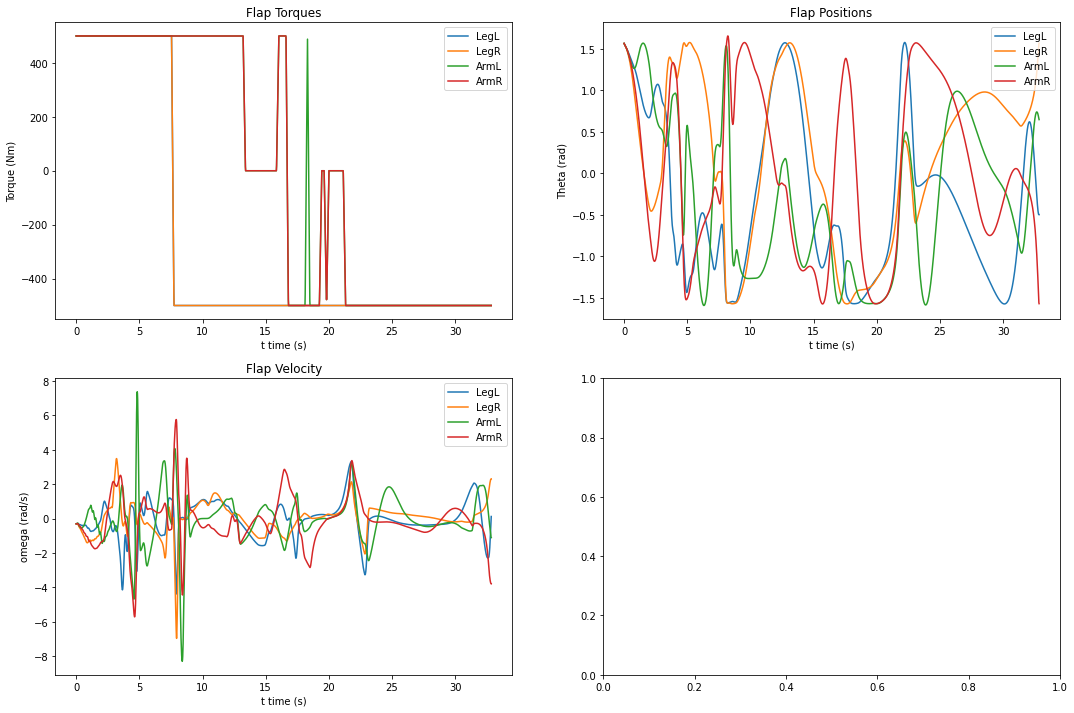

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18,12))
ax[0,0].plot(t, u_log.T[:,:4])
ax[0,0].legend(["LegL","LegR","ArmL","ArmR"])
ax[0,0].set_xlabel("t time (s)")
ax[0,0].set_ylabel("Torque (Nm)")
ax[0,0].set_title("Flap Torques")

ax[0,1].plot(t, x_log.Joint_Leg_L_p)
ax[0,1].plot(t, x_log.Joint_Leg_R_p)
ax[0,1].plot(t, x_log.Joint_Arm_L_p)
ax[0,1].plot(t, x_log.Joint_Arm_R_p)
ax[0,1].legend(["LegL","LegR","ArmL","ArmR"])
ax[0,1].set_xlabel("t time (s)")
ax[0,1].set_ylabel("Theta (rad)")
ax[0,1].set_title("Flap Positions")

ax[1,0].plot(t, x_log.Joint_Leg_L_v)
ax[1,0].plot(t, x_log.Joint_Leg_R_v)
ax[1,0].plot(t, x_log.Joint_Arm_L_v)
ax[1,0].plot(t, x_log.Joint_Arm_R_v)
ax[1,0].legend(["LegL","LegR","ArmL","ArmR"])
ax[1,0].set_xlabel("t time (s)")
ax[1,0].set_ylabel("omega (rad/s)")
ax[1,0].set_title("Flap Velocity")

Text(0, 0.5, 'Thrust (MN)')

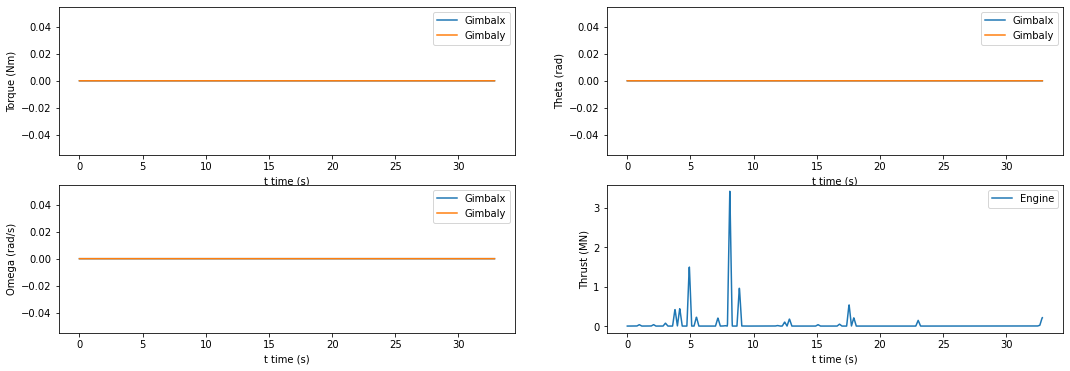

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18,6))
ax[0,0].plot(t, u_log.T[:,4:6])
ax[0,0].legend(["Gimbalx","Gimbaly"])
ax[0,0].set_xlabel("t time (s)")
ax[0,0].set_ylabel("Torque (Nm)")

ax[0,1].plot(t, x_log.Joint_Gimbal_x_p)
ax[0,1].plot(t, x_log.Joint_Gimbal_y_p)
ax[0,1].legend(["Gimbalx","Gimbaly"])
ax[0,1].set_xlabel("t time (s)")
ax[0,1].set_ylabel("Theta (rad)")

ax[1,0].plot(t, x_log.Joint_Gimbal_x_v)
ax[1,0].plot(t, x_log.Joint_Gimbal_y_v)
ax[1,0].legend(["Gimbalx","Gimbaly"])
ax[1,0].set_xlabel("t time (s)")
ax[1,0].set_ylabel("Omega (rad/s)")

ax[1,1].plot(t, u_log.T[:,6])
ax[1,1].legend(["Engine"])
ax[1,1].set_xlabel("t time (s)")
ax[1,1].set_ylabel("Thrust (MN)")

# Trajectory Stabilization

In [56]:
def finite_horizon_lqr(Q, R, x_traj = None, u_traj = None):
    builder = DiagramBuilder()

    starship = Starship(0)
    starship_system = builder.AddSystem(starship.GetDiagram())
    starship_plant = starship.GetPlant()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder,
                    starship_system.GetOutputPort("geometry_query"), meshcat)
    
    meshcat.Delete()

    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = Q

    options.x0 = x_traj
    if not u_traj is None:
        options.u0 = u_traj
    else:
        options.u0 = PiecewisePolynomial.FirstOrderHold([x_traj.start_time(),x_traj.end_time()], np.column_stack((np.zeros(4), np.zeros(4))))
    options.input_port_index = starship_system.GetInputPort("input").get_index()
    
    context = starship.CreateDefaultContext()
    #plant_context = starship_plant.GetMyMutableContextFromRoot(context)
    controller = builder.AddSystem(MakeFiniteHorizonLinearQuadraticRegulator(
            system = starship_system,
            context = context,
            t0 = x_traj.start_time(),
            tf = x_traj.end_time(),
            Q = Q,
            R = R,
            options = options))
    
    builder.Connect(controller.get_output_port(), starship_system.get_input_port())
    builder.Connect(starship_system.GetOutputPort('state'), controller.get_input_port())
    loggU = LogVectorOutput(controller.get_output_port(), builder)
    loggX = LogVectorOutput(starship_system.GetOutputPort('state'), builder)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    plant_context = starship_plant.GetMyContextFromRoot(sim_context)

    sim_context.SetTime(x_traj.start_time())
    initial_state = x_traj.value(x_traj.start_time())
    plant_context.SetContinuousState(initial_state)

    simulator.set_target_realtime_rate(1.0)
    simulator.Initialize()

    q = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])

    animator = visualizer.StartRecording()
    for t in np.hstack((np.arange(x_traj.start_time() , x_traj.end_time(), 1.0/32.0), x_traj.end_time())):
        q = np.hstack([starship_plant.GetPositions(plant_context),  starship_plant.GetVelocities(plant_context)])
        frame = animator.frame(t)
        sq = starship.StateView(q)
        animator.SetProperty(frame, "/Cameras/default/rotated/<object>", "position", [0, 0, 50])
        animator.SetTransform(frame, "/drake", RigidTransform(p = [-sq.body_x, -sq.body_y, -sq.body_z]))

        simulator.AdvanceTo(t)
        diagram.Publish(sim_context)

    visualizer.PublishRecording()
    return loggX.FindLog(sim_context), loggU.FindLog(sim_context)




# Stabilize FLip UP

In [ ]:
X_WB = RigidTransform(RotationMatrix.MakeYRotation(0.9*-np.pi/2),[0, 0, 250])
V_WB = SpatialVelocity(w=[0, 0, 0], v=[0,0,-60]) #change x velocity for instablility 
q0, _ = getq0(X_WB, V_WB, -1)

X_WB = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2),[0, 0, 250])
q1, _ = getq0(X_WB, V_WB, -1)
#q1 = starship.StateView(q0[:])
#q1.body_vx = 20

x_traj = PiecewisePolynomial.FirstOrderHold(
        [0., 8], np.column_stack((q0[:], q1[:])))

Q = np.diag([10,10,10,10,0,0,0, #body
             10,10,10,10, #joint positinos
             0,0,0,0,0,0, #body veelocity
             0,0,0,0])


R = np.diag([0.01, 0.01, 0.01, 0.01])

log_x, log_u = finite_horizon_lqr(Q,R, x_traj=x_traj) #todo pass in inputs from trajectory optimization

In [57]:
Q = np.diag([10,10,10,10,0,0,0, #body
             10,10,10,10, #joint positinos
             0,0,0,0,0,0, #body veelocity
             0,0,0,0])


R = np.diag([0.001, 0.001, 0.001, 0.001])

log_x, log_u = finite_horizon_lqr(Q,R, standup[0], standup[1])

In [ ]:
x_out = starship.StateView(log_x.data())
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_out.body_vz)

In [ ]:
for i in range(4):
    print(np.sum(np.square(log_u.data()[i,:])))